<a href="https://colab.research.google.com/github/dinhngoc267/NSEEN/blob/master/NSEEN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
pip install -U strsimpy

     |████████████████████████████████| 51kB 3.2MB/s 


In [ ]:
pip install faiss-cpu --no-cache

     |████████████████████████████████| 7.2MB 5.5MB/s 


In [ ]:
!pip install ipython-autotime
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=205f6735859ca23ee51d94a86e73e6aed815ff428b2c9c59b68c916e9de2171b
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [ ]:
import tensorflow as tf
from strsimpy.jaro_winkler import JaroWinkler
import xml.etree.ElementTree as ET
import os
import numpy as np
from itertools import combinations
import random
from keras.preprocessing.sequence import pad_sequences
import copy
import re
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from __future__ import absolute_import
from __future__ import print_function
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Embedding, Bidirectional, LSTM, InputLayer, GRU
from keras.optimizers import RMSprop
from keras import backend as K
from keras.optimizers import Adam
import math
import csv
import faiss
import nltk
import matplotlib.pyplot as plt

time: 19.6 ms


In [ ]:
def load_reference_dict(data_dir):
  reference_dict = {};
  tsv_file = open(data_dir); 
  read_tsv = csv.reader(tsv_file, delimiter="\n")

  for row in read_tsv:
    arr = row[0].split(': '); 
    values = [];
    variant_names = arr[1].split('\t');
    
    for name in variant_names:
      values.append(name)  
    reference_dict[arr[0]] = values

  reference_dict_copy = copy.deepcopy(reference_dict) 
  return reference_dict, reference_dict_copy

def char_to_int_dict(reference_dict): 
  text = "" 
  for key, values in reference_dict.items(): 
    for value in values: 
      text = text + value 
  vocab = sorted(set(text)) 
  return dict((c,i+1) for i,c in enumerate(vocab))

def get_maxlen_sequence(reference_dict): 
  maxlen=0 
  for key, values in reference_dict.items(): 
    for value in values: 
      if maxlen < len(value): 
        maxlen = len(value) 
  return maxlen

def split_character(word): 
  return [char for char in word]

#convert char sequence to int sequence in reference set and pad sequence
def embedding_dataset(data,maxlen, char_to_int): 
  idx = 0 
  for values in data: 
    value_1 = [char_to_int[c] for c in values[0]]; 
    value_2 = [char_to_int[c] for c in values[1]];
    data[idx] = pad_sequences([value_1, value_2],maxlen,padding= 'post') 
    idx += 1; 
  return data;

def create_random_list(list_size, population):
  sample = [] 
  count = 0 
  while count < list_size: 
    index = np.random.randint(0, len(population), size=1) 
    if population[index[0]] != 0: 
      sample.append(index[0]) 
      population[index[0]] = 0 
      count += 1

  return sample, population

#Prepare 3 sub dataset
#1.Semantic
def create_sematic_pairs(reference_dict):
  #Positive pairs
  sematic_pairs = []; 
  labels = [];

  for key,values in reference_dict.items(): 
    lst = []; n = len(values); 
    if n < 50:
      for pair in combinations(values,2):
        sematic_pairs.append(pair);
        labels.append((1,1))
    else:
      for value in values[1:]:
        sematic_pairs.append((values[0],value));
        labels.append((1,1))
  print("There are ",len(sematic_pairs)," positive pairs in sematic set")

  #Negative sematic pairs
  refer_list = [];
  
  for key, values in reference_dict.items():
    refer_list.append(values);

  count = 0;
  for i in range(0, len(refer_list)-1):
    value_1 = refer_list[i][0];
    if len(refer_list[i+1]) >=3:
      #value_2 = random.sample(list(refer_list[i+1]), 3);
      sematic_pairs.append((value_1, refer_list[i+1][0]));
      sematic_pairs.append((value_1, refer_list[i+1][1]));
      sematic_pairs.append((value_1, refer_list[i+1][2]));
      labels.append((0,0));
      labels.append((0,0));
      labels.append((0,0));
      count += 3;
    if len(refer_list[i+1]) == 2:
      #value_2 = random.sample(list(refer_list[i+1]), 2);
      sematic_pairs.append((value_1, refer_list[i+1][0]));
      sematic_pairs.append((value_1, refer_list[i+1][1]));
      labels.append((0,0));
      labels.append((0,0));
      count += 2;
    if len(refer_list[i+1]) == 1:
      #value_2 = random.sample(list(refer_list[i+1]), 1);
      sematic_pairs.append((value_1, refer_list[i+1][0]));
      labels.append((0,0));
      count += 1;
  print("There are ",count ," negative pairs in sematic set") 
  return sematic_pairs, labels


def create_syntactic_pairs(reference_dict):

#Create Syntatic Variations
  syntactic_pairs = []; 
  labels = []; 
  
  #Same name syntactic
  for key, values in reference_dict.items(): 
    for value in values:
      modified_str = copy.deepcopy(value);
      #1. Find all sequence contain characters which are not alphanumerical. If '-' character then replace with ' '. Else remove.     
      if '-' in value:        
        modified_str = modified_str.replace('-', ' ');
      #2. Convert to lower cases.      
      if value.islower() == False: #and value.lower() not in values:
        modified_str = modified_str.lower();
      #3. Remove 's / s in  tions -> tion 
      if "'s" in value:
        modified_str = modified_str.replace("'s","");
      if "'" in value:
        modified_str = modified_str.replace("'","");        
      
      if modified_str != value and modified_str not in values:
        syntactic_pairs.append((value, modified_str));
        #print(values[0],',',modified_str);
  
  # Different name syntactic
    
    # Từ viết tắt: 
      # low density lipoprotin -> ldl
      # high density lipoprotein -> hdl
      # injection site -> is
      # injection site reaction -> isr/ isrs
      # Haemoglobin -> hb
      # Diastolic blood presures ->dbp
      # magnetic resonance imagining -> mri
      # Whilte blood cell -> WBC
      # absolute neutrophil count -> anc
      # greater than -> '>'
      # less than -> < / below
      # per -> / 
      # < -> less than
      # < -> below

    # Cú pháp: 
      # tions -> tion
      # than && values -> bỏ values 
      # number + times -> number*
      # increased ở cuối -> increase/increase in đầu
      # decreased cuối -> reduce đầu/ low đầu
      # infection cuối -> infections đầu

  for key, values in reference_dict.items():
    for value in values:       
      # low density lipoprotein -> ldl
      if 'low density lipoprotein' in value.lower(): 
        modified_str = value.lower();
        modified_str = modified_str.replace("low density lipoprotein","ldl");

        if modified_str not in values:
          syntactic_pairs.append((value, modified_str));
          #print(values[0],',',modified_str);
      # high density lipoprotein -> hdl
      if 'high density lipoprotein' in value.lower(): 
        modified_str = value.lower();
        modified_str = modified_str.replace("high density lipoprotein","hdl");

        if modified_str not in values:
          syntactic_pairs.append((value, modified_str));
          #print(values[0],',',modified_str);
      # injection site -> is
      if 'injection site' in value.lower(): 
        modified_str = value.lower();
        modified_str = modified_str.replace("injection site","is");

        if modified_str not in values:
          syntactic_pairs.append((value, modified_str));
          #print(values[0],',',modified_str);
      # injection site reaction -> isr/ isrs
      if 'injection site reaction' in value.lower(): 
        modified_str = value.lower();
        modified_str_1 = modified_str.replace("injection site reaction","isr");

        if modified_str_1 not in values:
          syntactic_pairs.append((value, modified_str_1));
          #print(values[0],',',modified_str_1);

        modified_str_2 = modified_str.replace("injection site reaction","isrs");

        if modified_str_2 not in values:
          syntactic_pairs.append((value, modified_str_2));
          #print(values[0],',',modified_str_2);
      # Haemoglobin -> hb
      if 'haemoglobin' in value.lower(): 
        modified_str = value.lower();
        modified_str = modified_str.replace("haemoglobin","hb");

        if modified_str not in values:
          syntactic_pairs.append((value, modified_str));
          #print(values[0],',',modified_str);
      # Diastolic blood pressure ->dbp
      if 'diastolic blood pressure' in value.lower(): 
        modified_str = value.lower();
        modified_str = modified_str.replace("diastolic blood pressure","dbp");

        if modified_str not in values:
          syntactic_pairs.append((value, modified_str));
          #print(values[0],',',modified_str);
      # magnetic resonance imaging -> mri
      if 'magnetic resonance imaging' in value.lower(): 
        modified_str = value.lower();
        modified_str = modified_str.replace("magnetic resonance imaging","mri");

        if modified_str not in values:
          syntactic_pairs.append((value, modified_str));
          #print(values[0],',',modified_str);
      # White blood cell -> wbc
      if 'white blood cell' in value.lower(): 
        modified_str = value.lower();
        modified_str = modified_str.replace("white blood cell","wbc");

        if modified_str not in values:
          syntactic_pairs.append((value, modified_str));
          #print(values[0],',',modified_str);
      # absolute neutrophil count -> anc
      if 'absolute neutrophil count' in value.lower():
        modified_str = value.lower(); 
        modified_str = modified_str.replace("absolute neutrophil count","anc");

        if modified_str not in values:
          syntactic_pairs.append((value, modified_str));
          #print(values[0],',',modified_str);
      # greater than -> '>'
      if 'greater than' in value.lower():
        modified_str = value.lower(); 
        modified_str = modified_str.replace("greater than",">");

        if modified_str not in values:
          syntactic_pairs.append((value, modified_str));
          #print(values[0],',',modified_str);
      # less than -> < / below
      if 'less than' in value.lower(): 
        modified_str = value.lower(); 
        modified_str_1 = modified_str.replace("less than","<");

        if modified_str_1 not in values:
          syntactic_pairs.append((value, modified_str_1));
          #print(values[0],',',modified_str_1);

        modified_str_2 = modified_str.replace("less than","below");

        if modified_str_2 not in values:
          syntactic_pairs.append((value, modified_str_2));
          #print(values[0],',',modified_str_2);
      # per -> / 
      if ' per ' in value.lower(): 
        modified_str = value.lower(); 
        modified_str = modified_str.replace(" per ","/");

        if modified_str not in values:
          syntactic_pairs.append((value, modified_str));
          #print(values[0],',',modified_str);
      # < -> less than/below
      if '<' in value.lower(): 
        modified_str = value.lower(); 
        modified_str_1 = modified_str.replace("<","less than");

        if modified_str_1 not in values:
          syntactic_pairs.append((value, modified_str_1));
          #print(values[0],',',modified_str_1);

        modified_str_2 = modified_str.replace("<","below");

        if modified_str_2 not in values:
          syntactic_pairs.append((value, modified_str_2));
          #print(values[0],',',modified_str_2);

      # than && values -> bỏ values 
      if ' than ' in value.lower() and ' values ' in value.lower():
        modified_str = value.lower(); 
        modified_str = modified_str.replace(" values ","");

        if modified_str not in values:
          syntactic_pairs.append((value, modified_str));
          #print(values[0],',',modified_str);

      # number + times -> number*
      if ' times ' in value.lower():
        modified_str = value.lower(); 
        modified_str = modified_str.replace(" times ","*");

        if modified_str not in values:
          syntactic_pairs.append((value, modified_str));
          #print(values[0],',',modified_str);
      # increased ở cuối -> increase/increase in đầu
      if 'increase' in value.split(" ")[-1]:
        arr = value.lower().split(" ");
        modified_str = "increases"
        for term in arr[0:len(arr)-1]:
          modified_str = modified_str + " " + term;

        if modified_str not in values:
          syntactic_pairs.append((value, modified_str));
          #print(values[0],',',modified_str);
        
        modified_str = "increase in"
        for term in arr[0:len(arr)-1]:
          modified_str = modified_str + " " + term;

        if modified_str not in values:
          syntactic_pairs.append((value, modified_str));
          #print(values[0],',',modified_str);

      # decreased cuối -> reduce đầu/ low đầu
      if 'decrease' in value.split(" ")[-1]  :
        arr = value.lower().split(" ");
        modified_str = "reduce"
        for term in arr[0:len(arr)-1]:
          modified_str = modified_str + " " + term;

        if modified_str not in values:
          syntactic_pairs.append((value, modified_str));
          #print(values[0],',',modified_str);
        
        modified_str = "low"
        for term in arr[0:len(arr)-1]:
          modified_str = modified_str + " " + term;

        if modified_str not in values:
          syntactic_pairs.append((value, modified_str));
          #print(values[0],',',modified_str);
      # infection cuối -> infections đầu
      if 'infection' in value.split(" ")[-1]:
        arr = value.lower().split(" ");
        modified_str = "infections"
        for term in arr[0:len(arr)-1]:
          modified_str = modified_str + " " + term;

        if modified_str not in values:
          syntactic_pairs.append((value, modified_str));
          #print(values[0],',',modified_str);


  #Calculate the similarity between pair 
  jarowinkler = JaroWinkler()
  for i,pair in enumerate(syntactic_pairs): 
    similarity = jarowinkler.similarity(pair[0], pair[1])
    if (pair[0].isupper() or pair[1].isupper()) and pair[0].lower() == pair[1].lower() and len(pair[0]) <= 10:
      similarity = 0.9;
    labels.append((similarity,1));

  print("There are", len(syntactic_pairs), "syntactic pairs") 
  return syntactic_pairs, labels
 

def cosine_distance(vects): 
  x,y=vects  
  t1_norm = tf.nn.l2_normalize(x, axis = 1)
  t2_norm = tf.nn.l2_normalize(y, axis = 1)

  cosine =  -tf.losses.cosine_similarity(t1_norm, t2_norm, axis = 1)
  return 1-cosine

def cos_dist_output_shape(shapes): 
  shape1, shape2 = shapes 
  return (shape1[0], 1)

def contrastive_loss(y, d):
  #d: distance; y: labels
  margin = 1
  return K.mean((y) * K.square(d) + (1-y)*K.square(K.maximum(margin - d, 0)))

def create_base_network(input_shape): 
  model = Sequential()

  model.add(GRU(64,recurrent_dropout=0.2,return_sequences=True,  input_shape=input_shape));
  model.add(Bidirectional(LSTM(64, return_sequences=True)))
  model.add(Dropout(0.4))
  model.add(Bidirectional(LSTM(64, return_sequences=False)))
  model.add(Dropout(0.4)) 
  model.add(Dense(128, activation='relu'))
  return model

def shuffle_data(data, labels): 
  indices = np.arange(data.shape[0]) 
  np.random.shuffle(indices) 
  data = data[indices]
  labels = labels[indices] 
  return data, labels


#Define Siamese network
def Siamese_network(input_shape, dataset, labels, weights_file, save_dir): 
  base_network = create_base_network(input_shape);
  input_a = Input(shape=input_shape);
  input_b = Input(shape=input_shape);

  processed_a = base_network(input_a);
  processed_b = base_network(input_b);

  distance = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([processed_a, processed_b]);
  model = Model([input_a, input_b], distance);
 
  history = None;
  if weights_file =="":
    model.compile(loss=contrastive_loss, optimizer=Adam(learning_rate=0.00001))

    pop = [];
    for i in range(0, len(training_set)):
      pop.append(i+1);

    count = 0;
    max_count = np.ceil(len(training_set)/1024);

    filepath="/content/drive/My Drive/Colab Notebooks/NSEEN-weights-model-23.07.20-train_siamese_net-4_BiLSTM_layers-{epoch:02d}-{loss:.6f}.hdf5";
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1 , mode='min');
    callbacks_list = [checkpoint, myCallback("")];

    train_gen = generator(training_set, training_labels, pop, count,max_count)  
    history = model.fit_generator(train_gen,
                  steps_per_epoch =  np.ceil(len(training_set)/1024),
                  epochs=5,
                  callbacks=callbacks_list)
  else: 
    model.load_weights(weights_file) ;
    model.compile(loss=contrastive_loss, optimizer=Adam(learning_rate=0.00001)) 
  return model, history;
import keras
class myCallback(keras.callbacks.Callback):
  def __init__(self, save_dir):
    self.max_acc = 0;
    self.save_dir = save_dir;
  # Khi kết thúc mỗi epoch cần embed lại reference set và predict lại evaluate data (biểu diễn lại chuỗi dựa vào mô hình học)
  def on_epoch_end(self, epoch, logs=None):
    model_base = self.model.layers[2];
    reference_embeddings = model_base.predict(reference_vecs, batch_size=512);
    predicted_dev = model_base.predict(dev_set,batch_size=512);

    index = faiss.IndexFlatIP(128)   # build the index

    prev = copy.deepcopy(predicted_dev);
    reference = copy.deepcopy(reference_embeddings);
    faiss.normalize_L2(prev)  
    faiss.normalize_L2(reference)

    index.add(reference)
    D, I = index.search(prev,10);

    #index.add(reference_embeddings) 

    #D,I = index.search(predicted_dev[0:], 10) # Trả về index trong mảng 1 chiều sau khi đã flatten. 
                                                      # Cần biết vị trí của vector trong tập reference. -> Dựa vào reference_vecs_pos
    result = [];
    list_id = [];
    for i in range(0,len(predicted_dev)):
      tmp = [];
      lst = [];
      for j in range(0,10):
        idx = I[i][j]      # I là mảng 2 chiều. vì chỉ đi tìm neighbors của 1 vector nên lấy dòng đầu tiên và cột thứ j
        tmp.append(reference_list[idx]);
        lst.append(reference_list_idx[idx][1]);
      result.append(tmp);
      list_id.append(lst)
    
    n_hit_1 = 0; n_hit_3 = 0; n_hit_5 = 0; n_hit_10 = 0;

    for i in range(0,len(result)):
      flag = False;
      for j in range(0,1):
        if evaluate_dev[i,2] == list_id[i][j]:
          flag = True;
          n_hit_1 += 1;
          n_hit_3 += 1;
          n_hit_5 += 1;
          n_hit_10 += 1;
          break;
      if flag == False:
        for j in range(1,3):
          if evaluate_dev[i,2] == list_id[i][j]:
            flag = True;
            n_hit_3 += 1;
            n_hit_5 += 1;
            n_hit_10 += 1;
            break;

        if flag == False:
          for j in range(3,5):
            if evaluate_dev[i,2] == list_id[i][j]:
              flag = True;
              n_hit_5 += 1;
              n_hit_10 += 1;
              break;
          
          if flag == False:
            for j in range(5,10):
              if evaluate_dev[i,2] == list_id[i][j]:
                flag = True;
                n_hit_10 += 1;
                break;

    print(n_hit_1, n_hit_3, n_hit_5, n_hit_10);
    avg_acc = (float((n_hit_1/len(predicted_dev))) + float((n_hit_3/len(predicted_dev))) + float((n_hit_5/len(predicted_dev))) + float((n_hit_10/len(predicted_dev))))/4;
    print('Average Accuray:', avg_acc*100,'%');
    print(D);



def flatten_dict(referece_dict): 
  reference_list = []; 
  reference_list_idx = [] # Save the index of term. 
  idx = 0; 
  for key, values in reference_dict.items(): 
    for value in values:
      reference_list.append(value) 
      reference_list_idx.append((idx, key)); 
      idx += 1;

  return (reference_list, reference_list_idx);



#cấu trúc dữ liệu: training_set = str, label drug, normalization_id,
def create_evaluate_data(dir): 
  evaluate_data = [];
  trees = []; #id in these file is int
  
  for fname in sorted(os.listdir(dir)): 
    if(fname[-4:] == '.xml'): 
      trees.append(ET.parse(os.path.join(dir,fname)))
  
  for tree in trees: 
    root = tree.getroot() 
    drug_label = root.attrib.get('drug');
    for reaction in root.iter('Reaction'):
      attribs = reaction.attrib    
      str_name = attribs.get('str')
      for normalization in reaction.iter('Normalization'):
        meddra_pt_id = normalization.attrib.get('meddra_pt_id');
        nor_id = normalization.attrib.get('id');
        if meddra_pt_id is not None:         
          evaluate_data.append((str_name, drug_label, meddra_pt_id , nor_id));
  return evaluate_data

def generator(data, labels, pop, count, max_count, batch_size=1024):
  while 1:
    n = batch_size;    
    if count == max_count-1:
      n = len(data) - (max_count-1)*1024;    
    indices, pop = create_random_list(n, pop);
    
    if count == max_count - 1:
      pop = [];
      for i in range(0, len(training_set)):
        pop.append(i+1);
      count = -1;

    np.random.shuffle(indices);
    samples = data[indices];
    target = labels[indices];
    count += 1;
    yield [samples[:,0],samples[:,1]], target[:,0];
  

time: 2.45 s


In [ ]:
# ===== LOAD BỘ THAM CHIẾU ĐÃ ĐƯỢC XỬ LÝ VÀ TẠO DỮ LIỆU HUẤN LUYỆN ===========

#Create reference dictionary of entities from the xml files.
#The value of each key is a sequence of characters. 
print("Creating reference dictionary...")
reference_dict, reference_dict_copy = load_reference_dict("/content/drive/My Drive/Colab Datasets/reference.tsv")
print("Size of reference: ", len(reference_dict))

#Creating 2 training set.
print("Creating training set including: ")
print("1. Creating sematic set...")
(sematic_pairs, sematic_labels) = create_sematic_pairs(reference_dict)
print("2. Creating syntactic set...")
(syntactic_pairs, syntactic_labels) = create_syntactic_pairs(reference_dict = reference_dict_copy)
#Now, we need to transform the sequence of characters into vector of integers so that we can feed into the model.
#Here, I use char to index method to embedd the sequence into vector. 
print("Concatenating sematic and syntactic sets...")
dataset = sematic_pairs + syntactic_pairs;
labels = sematic_labels + syntactic_labels;

print("Embedding the dataset into vec of integers...")
maxlen = get_maxlen_sequence(reference_dict)
print("Max len sequence: ", maxlen)
char_to_int = char_to_int_dict(reference_dict)
(reference_list, reference_list_idx) = flatten_dict(reference_dict)

reference_vecs = copy.deepcopy(reference_list)
idx = 0;
for value in reference_vecs: 
  reference_vecs[idx] = [char_to_int[c] for c in value];    
  idx +=1;
reference_vecs = pad_sequences(reference_vecs,maxlen,padding= 'post')
reference_vecs  = reference_vecs / 84
reference_vecs = np.reshape(reference_vecs, reference_vecs.shape + (1,));

#Tạo tập phát triển. 
evaluate_dev = create_evaluate_data('/content/drive/My Drive/Colab Datasets/TAC2017/dev_xml');
evaluate_dev = np.array(evaluate_dev, dtype='object');

dev_set = copy.deepcopy(evaluate_dev[:,0])
idx = 0;
for value in dev_set: 
  dev_set[idx] = [char_to_int[c] for c in value];    
  idx +=1;
dev_set = pad_sequences(dev_set, maxlen, padding='post')
dev_set = dev_set / 84
dev_set = np.reshape(dev_set, dev_set.shape + (1,))


training_set = sematic_pairs + syntactic_pairs;
training_labels = sematic_labels + syntactic_labels;

training_set = embedding_dataset(training_set, maxlen,char_to_int)
training_set = np.array(training_set, dtype='object');
training_set = training_set / 84;
training_labels = np.array(training_labels, dtype='object');
print("Shuffle data...")
(training_set, training_labels) = shuffle_data(training_set, training_labels);

print("Reshape data into the shape of (samples, timestep, features)...")
training_set = np.reshape(training_set, training_set.shape + (1,))

Creating reference dictionary...
Size of reference:  21278
Creating training set including: 
1. Creating sematic set...
There are  232037  positive pairs in sematic set
There are  41549  negative pairs in sematic set
2. Creating syntactic set...
There are 72695 syntactic pairs
Concatenating sematic and syntactic sets...
Embedding the dataset into vec of integers...
Max len sequence:  100
Shuffle data...
Reshape data into the shape of (samples, timestep, features)...
time: 23.7 s


Phân tích tập tham chiếu:
- Tổng số thực thể:  21278
- Tổng số thuật ngữ:  68435
- Số lượng thuật ngữ trên một thực thể lớn nhất là:  278
- Biểu đồ phân phối:




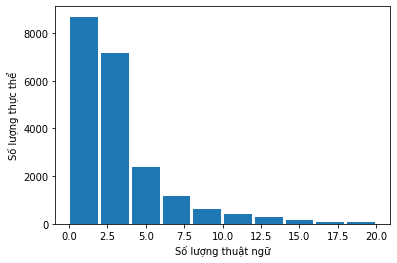


Phân tích bộ dữ liệu truy vấn:
- Tổng số truy vấn trong tập phát triển:  1651
- Tổng số truy vấn trong tập kiểm định:  6391
time: 587 ms


In [ ]:
# -----  PHÂN TÍCH BỘ THAM CHIẾU ---------

ref_distribution = [];
max_n = 0;
n_term = 0;
for key, values in reference_dict.items():
  n_term += len(values)
  n = len(values);
  ref_distribution.append(len(values))
  if n > max_n:
    max_n = n 
print('Phân tích tập tham chiếu:')
print('- Tổng số thực thể: ',len(reference_dict))
print('- Tổng số thuật ngữ: ',n_term)
print('- Số lượng thuật ngữ trên một thực thể lớn nhất là: ', max_n)
print('- Biểu đồ phân phối:')
print('\n')
plt.hist(ref_distribution, range=(0,20), rwidth=0.9)
plt.xlabel('Số lượng thuật ngữ')
plt.ylabel('Số lượng thực thể')
plt.show()

# -----  PHÂN TÍCH BỘ DỮ LIỆU PHÁT TRIỂN VÀ KIỂM ĐỊNH    ---------

#Tạo tập phát triển. 
evaluate_dev = create_evaluate_data('/content/drive/My Drive/Colab Datasets/TAC2017/dev_xml');

#Tạo tập kiểm định.
evaluate_test = create_evaluate_data('/content/drive/My Drive/Colab Datasets/TAC2017/gold_xml');
print('\nPhân tích bộ dữ liệu truy vấn:')
print('- Tổng số truy vấn trong tập phát triển: ',len(evaluate_dev))
print('- Tổng số truy vấn trong tập kiểm định: ',len(evaluate_test))

Huần luyện mô hình Siamese:

- Biểu đồ thể hiện giá trị loss qua 60 epochs



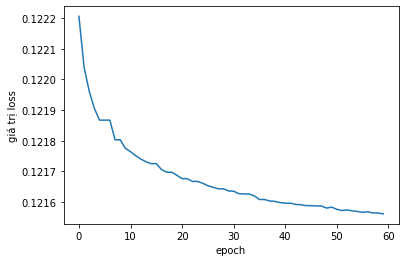

- Biểu đồ thể hiện giá trị độ chính xác qua 60 epochs



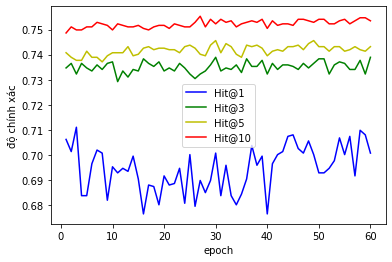




Thực hiện hard negative mining 2 lần với k = 2 (Lấy 2 cặp negative gần nhất):
- Lần 1 thu được 78,157 cặp negative:
- Biểu đồ thể hiện giá trị loss qua 40 epochs



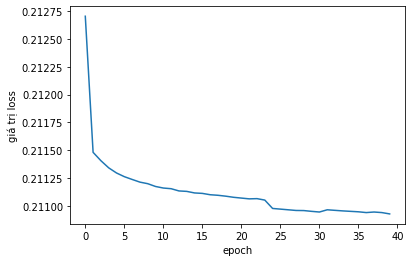

	- Biểu đồ thể hiện giá trị độ chính xác qua 40 epochs



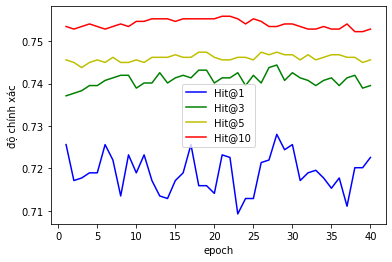

- Lần 2 thu được 77,267 cặp negative:
- Biểu đồ thể hiện giá trị loss qua 40 epochs



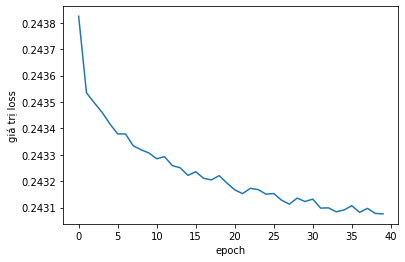

	- Biểu đồ thể hiện giá trị độ chính xác qua 40 epochs



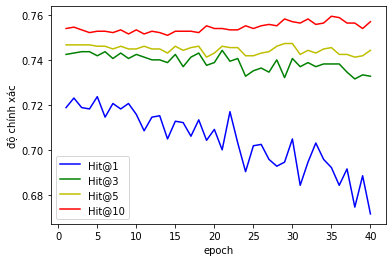

time: 1.43 s


In [ ]:
# -------- THỰC NGHIỆM -------------------

#-------- Huấn luyện mô hình Siamese----------
print('Huần luyện mô hình Siamese:\n')

tsv_file = open('/content/drive/My Drive/Colab Datasets/train_siamese-loss'); 
read_tsv = csv.reader(tsv_file, delimiter="\n")
loss = [];
for row in read_tsv:
  loss.append(float(row[0]))

print('- Biểu đồ thể hiện giá trị loss qua 60 epochs\n')
plt.plot(range(0, len(loss)), loss)
plt.xlabel('epoch')
plt.ylabel('giá trị loss')
plt.show()

tsv_file = open('/content/drive/My Drive/Colab Datasets/train_siamese-acc'); 
read_tsv = csv.reader(tsv_file, delimiter="\n")
acc = [];
for row in read_tsv:
  tmp = row[0].split('-')
  tmp = [float(tmp[0]),float(tmp[1]), float(tmp[2]), float(tmp[3])]
  acc.append(tmp)

hit_1 = []
hit_3 = []
hit_5 = []
hit_10 = []
for row in acc:
  hit_1.append(row[0])
  hit_3.append(row[1])
  hit_5.append(row[2])
  hit_10.append(row[3])

print('- Biểu đồ thể hiện giá trị độ chính xác qua 60 epochs\n')

plt.plot( range(1,61),hit_1, 'b', label='Hit@1')
plt.plot(range(1,61), hit_3, 'g', label='Hit@3')
plt.plot( range(1,61), hit_5,'y', label='Hit@5')
plt.plot( range(1,61),hit_10, 'r', label='Hit@10')
plt.xlabel('epoch')
plt.ylabel('độ chính xác')
plt.legend()
plt.show()


# ------------- Hard negative mining --------- 
print('\n\n')
print('Thực hiện hard negative mining 2 lần với k = 2 (Lấy 2 cặp negative gần nhất):')
print('- Lần 1 thu được 78,157 cặp negative:')

tsv_file = open('/content/drive/My Drive/Colab Datasets/hard_negative_mining_1-loss'); 
read_tsv = csv.reader(tsv_file, delimiter="\n")
loss = [];
for row in read_tsv:
  loss.append(float(row[0]))

print('- Biểu đồ thể hiện giá trị loss qua 40 epochs\n')
plt.plot(range(0, len(loss)), loss)
plt.xlabel('epoch')
plt.ylabel('giá trị loss')
plt.show()

tsv_file = open('/content/drive/My Drive/Colab Datasets/hard_negative_mining_1-acc'); 
read_tsv = csv.reader(tsv_file, delimiter="\n")
acc = [];
for row in read_tsv:
  tmp = row[0].split('-')
  tmp = [float(tmp[0]),float(tmp[1]), float(tmp[2]), float(tmp[3])]
  acc.append(tmp)

hit_1 = []
hit_3 = []
hit_5 = []
hit_10 = []
for row in acc:
  hit_1.append(row[0])
  hit_3.append(row[1])
  hit_5.append(row[2])
  hit_10.append(row[3])

print('\t- Biểu đồ thể hiện giá trị độ chính xác qua 40 epochs\n')

plt.plot( range(1,len(hit_1)+1),hit_1, 'b', label='Hit@1')
plt.plot(range(1,len(hit_1)+1), hit_3, 'g', label='Hit@3')
plt.plot( range(1,len(hit_1)+1), hit_5,'y', label='Hit@5')
plt.plot( range(1,len(hit_1)+1),hit_10, 'r', label='Hit@10')
plt.xlabel('epoch')
plt.ylabel('độ chính xác')
plt.legend()
plt.show()

print('- Lần 2 thu được 77,267 cặp negative:')

tsv_file = open('/content/drive/My Drive/Colab Datasets/hard_negative_mining_2-loss'); 
read_tsv = csv.reader(tsv_file, delimiter="\n")
loss = [];
for row in read_tsv:
  loss.append(float(row[0]))

print('- Biểu đồ thể hiện giá trị loss qua 40 epochs\n')
plt.plot(range(0, len(loss)), loss)
plt.xlabel('epoch')
plt.ylabel('giá trị loss')
plt.show()


tsv_file = open('/content/drive/My Drive/Colab Datasets/hard_negative_mining_2-acc'); 
read_tsv = csv.reader(tsv_file, delimiter="\n")
acc = [];
for row in read_tsv:
  tmp = row[0].split('-')
  tmp = [float(tmp[0]),float(tmp[1]), float(tmp[2]), float(tmp[3])]
  acc.append(tmp)

hit_1 = []
hit_3 = []
hit_5 = []
hit_10 = []
for row in acc:
  hit_1.append(row[0])
  hit_3.append(row[1])
  hit_5.append(row[2])
  hit_10.append(row[3])

print('\t- Biểu đồ thể hiện giá trị độ chính xác qua 40 epochs\n')

plt.plot( range(1,len(hit_1)+1),hit_1, 'b', label='Hit@1')
plt.plot(range(1,len(hit_1)+1), hit_3, 'g', label='Hit@3')
plt.plot( range(1,len(hit_1)+1), hit_5,'y', label='Hit@5')
plt.plot( range(1,len(hit_1)+1),hit_10, 'r', label='Hit@10')
plt.xlabel('epoch')
plt.ylabel('độ chính xác')
plt.legend()
plt.show()

In [ ]:
# ------- KẾT QUẢ TRUY VẤN SAU KHI HARD NEGATIVE MINING TRÊN TẬP PHÁT TRIỂN --------
model_base = model.layers[2];
reference_embeddings = model_base.predict(reference_vecs, batch_size = 512);
predicted_dev = model_base.predict(dev_set, batch_size=512);

index = faiss.IndexFlatIP(128)   # build the index

prev = copy.deepcopy(predicted_dev);
reference = copy.deepcopy(reference_embeddings);
faiss.normalize_L2(prev)
faiss.normalize_L2(reference)
index.add(reference);
D, I = index.search(prev,10);

#index.add(reference_embeddings) 

#D,I = index.search(predicted_dev[0:], 10) # Trả về index trong mảng 1 chiều sau khi đã flatten. 
                                                  # Cần biết vị trí của vector trong tập reference. -> Dựa vào reference_vecs_pos
result = [];
list_id = [];
for i in range(0,len(predicted_dev)):
  tmp = [];
  lst = [];
  for j in range(0,10):
    idx = I[i][j]      # I là mảng 2 chiều. vì chỉ đi tìm neighbors của 1 vector nên lấy dòng đầu tiên và cột thứ j
    tmp.append(reference_list[idx]);
    lst.append(reference_list_idx[idx][1]);
  result.append(tmp);
  list_id.append(lst)

n_hit_1 = 0; n_hit_3 = 0; n_hit_5 = 0; n_hit_10 = 0;

for i in range(0,len(result)):
  flag = False;
  for j in range(0,1):
    if evaluate_dev[i,2] == list_id[i][j]:
      flag = True;
      n_hit_1 += 1;
      n_hit_3 += 1;
      n_hit_5 += 1;
      n_hit_10 += 1;
      break;
  if flag == False:
    for j in range(1,3):
      if evaluate_dev[i,2] == list_id[i][j]:
        flag = True;
        n_hit_3 += 1;
        n_hit_5 += 1;
        n_hit_10 += 1;
        break;

    if flag == False:
      for j in range(3,5):
        if evaluate_dev[i,2] == list_id[i][j]:
          flag = True;
          n_hit_5 += 1;
          n_hit_10 += 1;
          break;
      
      if flag == False:
        for j in range(5,10):
          if evaluate_dev[i,2] == list_id[i][j]:
            flag = True;
            n_hit_10 += 1;
            break;

print(n_hit_1, n_hit_3, n_hit_5, n_hit_10);
avg_acc = (float((n_hit_1/len(predicted_dev))) + float((n_hit_3/len(predicted_dev))) + float((n_hit_5/len(predicted_dev))) + float((n_hit_10/len(predicted_dev))))/4;
print('Average Accuray:', avg_acc*100,'%');


for i in range(0,len(result)):
  count = 0;
  for j in range(0,10):  
    if evaluate_dev[i,2] == list_id[i][j]: #and evaluate_dev[i,0].lower() != result[i][j].lower():
      count += 1;
  if count >= 3:
    for k in range(0,10):
      print(evaluate_dev[i,0],':',evaluate_dev[i,2],'-' , result[i][k],':', list_id[i][k])

1187 1224 1231 1241
Average Accuray: 73.94003634161115 %
hypersensitivity reactions : 10020751 - hypersensitivity reactions : 10020751
hypersensitivity reactions : 10020751 - hypersensitivity reaction : 10020751
hypersensitivity reactions : 10020751 - photosensitivity reaction : 10034972
hypersensitivity reactions : 10020751 - hypersensitivity skin reactions : 10012434
hypersensitivity reactions : 10020751 - hypersensitivity-related adverse reactions : 10020751
hypersensitivity reactions : 10020751 - photosensitivity-related adverse reactions : 10034972
hypersensitivity reactions : 10020751 - neurosensory hypoacusis : 10067587
hypersensitivity reactions : 10020751 - neuromuscular symptoms : 10029323
hypersensitivity reactions : 10020751 - hyperpigmentation on the soles : 10040865
hypersensitivity reactions : 10020751 - hyperpigmentation on the palms : 10040865
upper respiratory tract infection : 10046306 - upper respiratory tract infection : 10046306
upper respiratory tract infection :